In [1]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import csv
from torch import nn
from sklearn.utils import class_weight 
import numpy as np
from sklearn import metrics  
import matplotlib.pyplot as plt

torch.manual_seed(0)
DATAPATH = '/home/skrhakv/deeplife/binding-prediction--deeplife-lab/data'

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cuda'

# PART 1.
Use solely protein embeddings to predict the binding residues.

### use dataset API to load the Yu dataset

In [5]:
class SequenceYuDataset(Dataset):
    def __init__(self, _Xs, _Ys):
        Xs_list = None
        Ys_list = None
        for key in _Xs.keys():
            if Xs_list is None:
                Xs_list = _Xs[key]
                Ys_list = _Ys[key]
            else:
                Xs_list = np.concatenate((Xs_list,_Xs[key]), axis = 0)
                Ys_list = np.concatenate((Ys_list,_Ys[key]), axis = 0)

        self.Xs = torch.tensor(Xs_list, dtype=torch.float32)
        self.Ys = torch.tensor(Ys_list, dtype=torch.int64)

    def __len__(self):
        assert len(self.Xs) == len(self.Ys)
        return len(self.Xs)

    def __getitem__(self, idx):
        x = self.Xs[idx]
        y = self.Ys[idx]
        return x, y


### proccess the Yu dataset

In [6]:
def process_sequence_dataset(annotation_path, embeddings_path):
    Xs = {}
    Ys = {}
    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]
            
            if id not in Xs:
                filename = id + '.npy'
                embedding = np.load(f'{embeddings_path}/{filename}')
                Xs[id] = embedding

            if id not in Ys:
                Ys[id] = np.zeros(embedding.shape[0])
            for residue_idx in [int(residue[1:]) for residue in row[4].split(' ')]:
                # Yu dataset has 1-based indexing, so we need to subtract 1
                Ys[id][residue_idx - 1] = 1

    return Xs, Ys

In [47]:
Xs_train, Ys_train = process_sequence_dataset(f'{DATAPATH}/ADP_Training.txt', f'{DATAPATH}/embeddings')

train_dataset = SequenceYuDataset(Xs_train, Ys_train)

Xs_test, Ys_test = process_sequence_dataset(f'{DATAPATH}/ADP_Test.txt', f'{DATAPATH}/embeddings')

test_dataset = SequenceYuDataset(Xs_test, Ys_test)

In [48]:
print(len(train_dataset))
print(len(test_dataset))

102573
21013


### Define a classifier
Create a classifier to predict whether residue is part of a binding site

In [49]:
DROPOUT = 0.3
LAYER_WIDTH = 100

class YuClassifier(nn.Module):
    def __init__(self, input_dim=2560):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_dim, out_features=LAYER_WIDTH)
        self.dropout1 = nn.Dropout(DROPOUT)

        self.layer_2 = nn.Linear(in_features=LAYER_WIDTH, out_features=LAYER_WIDTH)
        self.dropout2 = nn.Dropout(DROPOUT)

        self.layer_3 = nn.Linear(in_features=LAYER_WIDTH, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.dropout1(self.relu(self.layer_2(self.dropout1(self.relu(self.layer_1(x)))))))


### Train imbalanced dataset
The dataset is heavily imbalanced (only ~5% of all residues are binding residues, the rest is non-binding), therefore we pass the `weight` argument for the loss function. But first, the weights need to be calculated using the `compute_class_weights(...)` function.

In [50]:
def compute_class_weights(labels):
    class_weights=class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights=torch.tensor(class_weights,dtype=torch.float)
    return class_weights

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

torch.manual_seed(42)

### Train loop

In [54]:
model_0 = YuClassifier().to(device)
epochs = 80

# Create an optimizer
optimizer = torch.optim.Adam(params=model_0.parameters(), 
                            lr=0.0001)

X_train, y_train = train_dataset[:]
X_test, y_test = test_dataset[:]

# compute class weights (because the dataset is heavily imbalanced)
class_weights = compute_class_weights(y_train.numpy()).to(device)
# BCEWithLogitsLoss - sigmoid is already built-in!
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

X_train, y_train = X_train.to(device), y_train.to(device).float()
X_test, y_test = X_test.to(device), y_test.to(device).float()

train_losses, test_losses = [], []

for epoch in range(epochs):
    ### TRAIN
    model_0.train()

    y_logits = model_0(X_train).squeeze() 
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits,
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    train_losses.append(loss.cpu().detach().numpy())

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    ### TEST
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,
                            y_test)
        test_losses.append(test_loss.cpu().detach().numpy())

        # compute metrics on test dataset
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        fpr, tpr, thresholds = metrics.roc_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
        roc_auc = metrics.auc(fpr, tpr)

        mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc}, MCC: {mcc}")

Epoch: 0 | Loss: 1.84645, Accuracy: 54.82% | Test loss: 0.90682, AUC: 0.6447920522776224, MCC: 0.09431623124467593
Epoch: 10 | Loss: 0.91228, Accuracy: 77.94% | Test loss: 0.53689, AUC: 0.8862689415806663, MCC: 0.3288766222214396
Epoch: 20 | Loss: 0.65476, Accuracy: 86.89% | Test loss: 0.47271, AUC: 0.9161451521271524, MCC: 0.4003342637058067
Epoch: 30 | Loss: 0.53018, Accuracy: 89.13% | Test loss: 0.43135, AUC: 0.9292828650973491, MCC: 0.42867217471228386
Epoch: 40 | Loss: 0.44872, Accuracy: 90.94% | Test loss: 0.41120, AUC: 0.936858134802108, MCC: 0.45838484260740364
Epoch: 50 | Loss: 0.39609, Accuracy: 91.95% | Test loss: 0.39935, AUC: 0.9416165231984747, MCC: 0.4719211726208164
Epoch: 60 | Loss: 0.34801, Accuracy: 93.02% | Test loss: 0.39526, AUC: 0.944924321168143, MCC: 0.4839506169321163
Epoch: 70 | Loss: 0.30509, Accuracy: 93.72% | Test loss: 0.39823, AUC: 0.9470008652984346, MCC: 0.4968146687885479


### Compare train and test loss

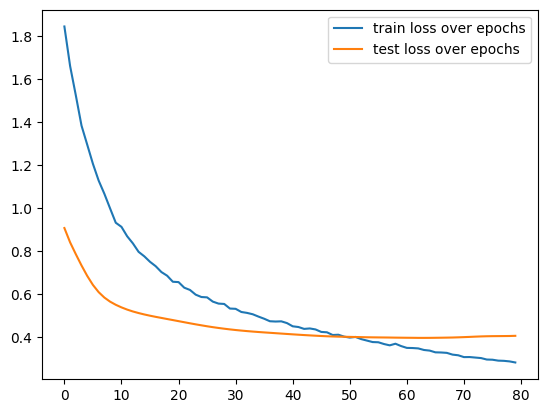

In [55]:

plt.plot(train_losses,label="train loss over epochs")
plt.plot(test_losses,label="test loss over epochs")
plt.legend()

### ROC curve
The dataset is imbalanced, therefore it is important to use a more complex metrics for evaluating the model appart from using only the accuracy (if we would predict everything as NON-BINDING, then we would achieve ~95% accuracy as most of the residues are NON-BINDING!).

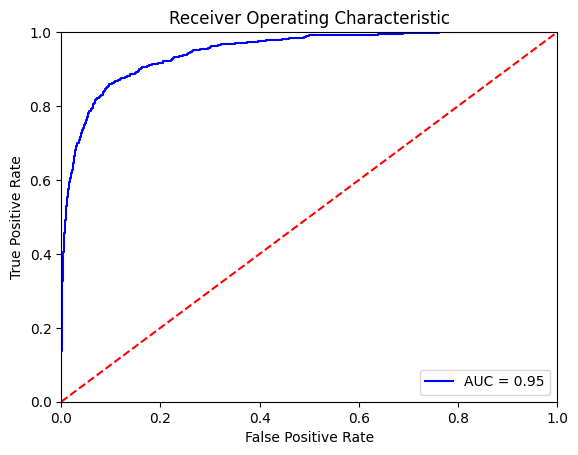

In [56]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Homework: Part 1
Create embeddings based on sequences from the annotation files using a different model (We'll give you hints for ProtBERT, but feel free to use model of your own choice - ProtT5, Ankh, ...)

In [6]:
from transformers import BertModel, BertTokenizer

tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
model = BertModel.from_pretrained("Rostlab/prot_bert")

GENERATE_EMBEDDINGS = False


### Try the model on an example sequence

In [15]:
protein_sequences = ['MKALCLLLLPVLGLLVSSKTLCSMEEAINERIQEVAGSLIFRAISSIGLECQSVTSRGDLATCPRGFAVTGCTCGSACGSWDVRAETTCHCQCAGMDWTGARCCRVQPLEHHHHHH', 
      'GSHMSLFDFFKNKGSAATATDRLKLILAKERTLNLPYMEEMRKEIIAVIQKYTKSSDIHFKTLDSNQSVETIEVEIILPR']

protein_sequences = [seq.replace("", " ")[1: -1] for seq in protein_sequences]
output = []
for seq in protein_sequences:
    encoded_input = tokenizer(seq, return_tensors='pt')
    
    # you need to strip the embedding of the first and last vector, as those are the starting and terminating signs
    output.append(model(**encoded_input).last_hidden_state.detach().numpy()[0][1:-1])

In [45]:
protein_sequences = ['MKALCLLLLPVLGLLVSSKTLCSMEEAINERIQEVAGSLIFRAISSIGLECQSVTSRGDLATCPRGFAVTGCTCGSACGSWDVRAETTCHCQCAGMDWTGARCCRVQPLEHHHHHH', 
      'GSHMSLFDFFKNKGSAATATDRLKLILAKERTLNLPYMEEMRKEIIAVIQKYTKSSDIHFKTLDSNQSVETIEVEIILPR']

for i, seq in zip(output, protein_sequences):
    print(f'Embedding shape: {i.shape}, sequence length: {len(seq)}')

Embedding shape: (116, 1024), sequence length: 116
Embedding shape: (80, 1024), sequence length: 80


### TASK 1.
Use the model to generate embeddings for the YU dataset used earlier


Hints:
1. The sequences can be found in the CSV files `ADP_Training.txt`, `ADP_Test.txt`.

In [20]:

def get_sequences(annotation_path):
    sequences = []
    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]
            sequence = row[5]
            sequences.append((id, sequence))

    return sequences

def create_embeddings(sequences, output_path):    
    with torch.no_grad():
        for sequence in sequences:
            print(f'Process {sequence[0]} ...')
            encoded_input = tokenizer(sequence[1].replace("", " ")[1: -1], return_tensors='pt')
            embedding = model(**encoded_input).last_hidden_state.detach().numpy()[0][1:-1]

            assert len(sequence[1]) == embedding.shape[0]
            with open(f'{output_path}/{sequence[0]}.npy', 'wb') as f:
                np.save(f, embedding)

In [21]:
if GENERATE_EMBEDDINGS:
    print("reading TRAIN sequences ...")
    train_sequences = get_sequences(f'{DATAPATH}/ADP_Training.txt')
    print("generating TRAIN embeddings ...")
    create_embeddings(train_sequences, f'{DATAPATH}/bert-embeddings')

    print("reading TEST sequences ...")
    test_sequences = get_sequences(f'{DATAPATH}/ADP_Test.txt')
    print("generating TRAIN embeddings ...")
    create_embeddings(test_sequences, f'{DATAPATH}/bert-embeddings')

reading TRAIN sequences ...
generating TRAIN embeddings ...
Process 2b9hA ...
Process 2fnaA ...
Process 1hi5A ...
Process 3kjiA ...
Process 1k3cA ...
Process 3llmA ...
Process 1nvaA ...
Process 1pkgA ...
Process 3nbxX ...
Process 3ko5A ...
Process 1fwkA ...
Process 2dcnA ...
Process 2axnA ...
Process 3g2fA ...
Process 1cnfA ...
Process 2awnA ...
Process 2qb5A ...
Process 2rd5A ...
Process 1r0yA ...
Process 1gzfC ...
Process 3dzvA ...
Process 1t6xA ...
Process 1iqpA ...
Process 2ch6A ...
Process 1e3mA ...
Process 3k1jA ...
Process 3hz6A ...
Process 1y63A ...
Process 1e4eA ...
Process 3ec2A ...
Process 1rfvA ...
Process 1z59A ...
Process 3i73A ...
Process 1a9xA ...
Process 1a9xA ...
Process 1xtjA ...
Process 1qf9A ...
Process 2qr1B ...
Process 1jj7A ...
Process 1b62A ...
Process 3akkA ...
Process 1tzdA ...
Process 2hehA ...
Process 3ouzA ...
Process 2a2cA ...
Process 3bfvA ...
Process 1r6bX ...
Process 1ao0A ...
Process 1ao0A ...
Process 1xjkA ...
Process 3pnlB ...
Process 3fwyA ...
Proc

In [57]:
np.load(f'{DATAPATH}/bert-embeddings/2fnaA.npy').shape

(352, 1024)

### TASK 2.
Use the novel embeddings to train a model for the binding-site prediction task, similarly as was shown earlier with the ESM-2 embeddings.
1. train the model using your novel embeddings
2. create the train/test loss graph
3. create the ROC curve: print the ROC curve for both models (the model trained on ESM-2 and your new model)


Hints:
1. You can reuse the code from earlier: `YuClassifier` class, `proccess_dataset(...)`, the train loop or the code for creating the plots
2. To train the model on ESM-2 using 80 epochs was enough. However, in the case of ProtBert, you might need to increase the number of epochs to train the model properly.
3. Don't worry if the ProtBert results don't match the ESM-2 results. It is expected as the ESM-2 model is more complex than the ProtBert model, therefore it might achieve better results. On the other hand, generating ProtBert embeddings isn't as time-consuming as generating ESM-2 embeddings (as trying out generating protein embeddings is the main point of this task). 

In [33]:
Xs_train, Ys_train = process_sequence_dataset(f'{DATAPATH}/ADP_Training.txt', f'{DATAPATH}/bert-embeddings')
train_dataset = SequenceYuDataset(Xs_train, Ys_train)

Xs_test, Ys_test = process_sequence_dataset(f'{DATAPATH}/ADP_Test.txt', f'{DATAPATH}/bert-embeddings')
test_dataset = SequenceYuDataset(Xs_test, Ys_test)

In [40]:

model_1 = YuClassifier(input_dim=1024).to(device)
epochs = 250

# Create an optimizer
optimizer = torch.optim.Adam(params=model_1.parameters(), 
                            lr=0.0001)

X_train, y_train = train_dataset[:]
X_test, y_test = test_dataset[:]

# compute class weights (because the dataset is heavily imbalanced)
class_weights = compute_class_weights(y_train.numpy()).to(device)
# BCEWithLogitsLoss = sigmoid is already built-in!
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

X_train, y_train = X_train.to(device), y_train.to(device).float()
X_test, y_test = X_test.to(device), y_test.to(device).float()

train_losses_1, test_losses_1 = [], []

for epoch in range(epochs):
    ### TRAIN
    model_1.train()

    y_logits = model_1(X_train).squeeze() 
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits,
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    train_losses_1.append(loss.cpu().detach().numpy())

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    ### TEST
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,
                            y_test)
        test_losses_1.append(test_loss.cpu().detach().numpy())

        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        fpr_1, tpr_1, thresholds = metrics.roc_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
        roc_auc_1 = metrics.auc(fpr_1, tpr_1)

        mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc_1}, MCC: {mcc}")

Epoch: 0 | Loss: 0.99885, Accuracy: 96.10% | Test loss: 0.95568, AUC: 0.46316368052889195, MCC: 0.0
Epoch: 10 | Loss: 0.99019, Accuracy: 96.26% | Test loss: 0.94660, AUC: 0.5873525439243299, MCC: 0.0
Epoch: 20 | Loss: 0.98060, Accuracy: 96.26% | Test loss: 0.93678, AUC: 0.634107739336484, MCC: 0.0
Epoch: 30 | Loss: 0.96967, Accuracy: 96.26% | Test loss: 0.92550, AUC: 0.6518529549159866, MCC: 0.0
Epoch: 40 | Loss: 0.95578, Accuracy: 96.26% | Test loss: 0.91212, AUC: 0.664096038516609, MCC: 0.0
Epoch: 50 | Loss: 0.94053, Accuracy: 96.27% | Test loss: 0.89633, AUC: 0.6793676666387939, MCC: 0.0
Epoch: 60 | Loss: 0.92228, Accuracy: 96.24% | Test loss: 0.87790, AUC: 0.6976660822950015, MCC: 0.09903955144546787
Epoch: 70 | Loss: 0.90181, Accuracy: 96.13% | Test loss: 0.85685, AUC: 0.7166121450723815, MCC: 0.1657694462389249
Epoch: 80 | Loss: 0.87971, Accuracy: 95.73% | Test loss: 0.83379, AUC: 0.7345176409437475, MCC: 0.19109324492307445
Epoch: 90 | Loss: 0.85758, Accuracy: 95.04% | Test loss

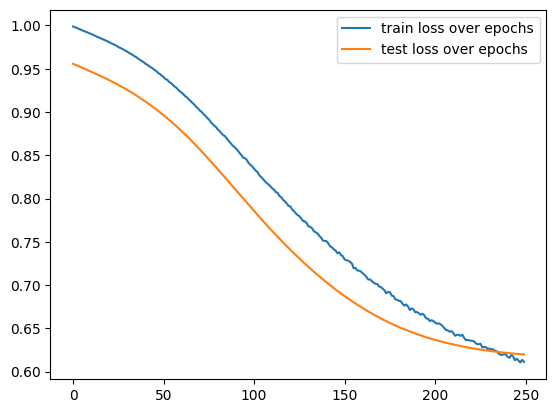

In [44]:
plt.plot(train_losses_1,label="train loss over epochs")
plt.plot(test_losses_1,label="test loss over epochs")
plt.legend()

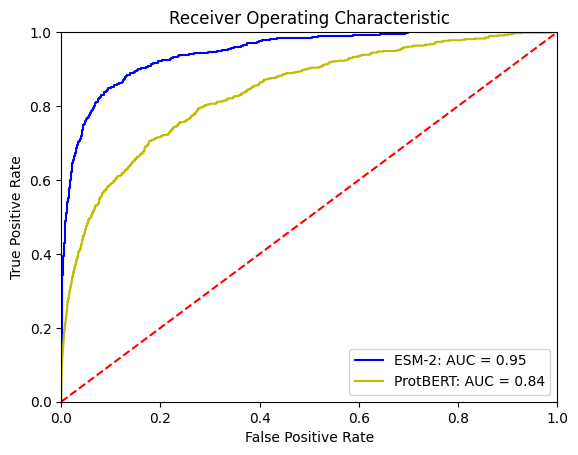

In [43]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'ESM-2: AUC = %0.2f' % roc_auc)
plt.plot(fpr_1, tpr_1, 'y', label = 'ProtBERT: AUC = %0.2f' % roc_auc_1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# PART 2.
Let's use structural information for predicting the binding regions. In the provided data, there are two folders - `voxel-features` with 3D `1x1x1 A^3` voxels, each containing eight channels (`hydrophobic`, `aromatic`, `hbond_acceptor`, `hbond_donor`, `positive_ionizable`, `negative_ionizable`, `metal`, `occupancies`) and `voxel-annotations` specifying the binding regions in each protein from the dataset. Overall,  the voxels create a 3D grid for each protein. The voxels were created using the [HTMD package](https://software.acellera.com/moleculekit/moleculekit.tools.voxeldescriptors.html). However, because installing & running the package can be time-consuming, we prepared the voxels in advance.


The whole exercise is loosely based on the [DeepSite method](https://academic.oup.com/bioinformatics/article/33/19/3036/3859178), which uses structure as its primary information source.

## Overview of the method
We split the 3D grid into `32x32x32` windows using `step=16`. Then, we train a CNN using the extracted 3D windows to predict, whether the window is part of a binding region or not.

### What is considered to be positive example
In our scenario, the `32x32x32` window is considered positive if at least one atom is derived from a binding residue. That's a significant simplification when compared to the original DeepSite paper, which states that the window is considered to be positive if its geometric center is closer than `4 A` to the pocket geometric center and negative otherwise. However, the simplified approach is sufficient for our purposes.


### Parameters
In real-world tools (like DeepSite), we might find out that the `WINDOW_SIZE` and `WINDOW_STEP` parameters might be finer (smaller window size with smaller steps). However, to reduce the computation time and resources, we set coarser windows.

In [174]:

WINDOW_SIZE = 32
WINDOW_STEP = 16

def sliding_window_3d(vector):
    vector = vector.unfold(1,WINDOW_SIZE,WINDOW_STEP)
    vector = vector.unfold(2,WINDOW_SIZE,WINDOW_STEP)
    vector = vector.unfold(3,WINDOW_SIZE,WINDOW_STEP)
    return vector.flatten(1, 3)


def pad_and_sliding_window_3d(x, y):
    pad1 = WINDOW_SIZE - x.shape[3] % WINDOW_SIZE if WINDOW_SIZE - x.shape[3] % WINDOW_SIZE > 0 else 0  
    pad2 = WINDOW_SIZE - x.shape[2] % WINDOW_SIZE if WINDOW_SIZE - x.shape[2] % WINDOW_SIZE > 0 else 0 
    pad3 = WINDOW_SIZE - x.shape[1] % WINDOW_SIZE if WINDOW_SIZE - x.shape[1] % WINDOW_SIZE > 0 else 0 
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.int8)

    x = F.pad(x, (int(pad1 / 2), int(pad1 / 2) + (pad1 % 2 > 0),
        int(pad2 / 2), int(pad2 / 2) + (pad2 % 2 > 0),
        int(pad3 / 2), int(pad3 / 2) + (pad3 % 2 > 0)), mode='constant', value=0)
    y = F.pad(y, (int(pad1 / 2), int(pad1 / 2) + (pad1 % 2 > 0),
        int(pad2 / 2), int(pad2 / 2) + (pad2 % 2 > 0),
        int(pad3 / 2), int(pad3 / 2) + (pad3 % 2 > 0)), mode='constant', value=0)
    x = sliding_window_3d(x)
    y = sliding_window_3d(y)
    
    return x,y

class VoxelYuDataset(Dataset):
    def __init__(self, _Xs, _Ys):
        self.Xs = None
        self.Ys = None
        counter = 1
        keys = list(_Xs.keys())
        for key in keys:
            print(key, ' ',counter, ' / ', len(keys), ' ')
            counter += 1
            
            x, y = pad_and_sliding_window_3d(_Xs[key], _Ys[key])
            y = y.sum(dim=[0,2,3,4]) > 0
            if self.Xs is None:
                self.Xs = x
                self.Ys = y
            else:
                self.Xs = torch.cat((self.Xs,x),1)
                self.Ys = torch.cat((self.Ys,y))
            
            if counter % 5 == 0:
                gc.collect()

            del _Xs[key]
            del _Ys[key]
        
        self.Xs = self.Xs.swapaxes(0,1)

    def __len__(self):
        assert len(self.Xs) == len(self.Ys)
        return len(self.Xs)

    def __getitem__(self, idx):
        x = self.Xs[idx]
        y = self.Ys[idx]
        return x, y

In [172]:
def proccess_voxel_dataset(annotation_path, voxel_features_path, voxel_annotation_path):
    Xs = {}
    Ys = {}
    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]
            filename = id + '.npy'
            
            if id not in Xs:
                voxel_features = np.load(f'{voxel_features_path}/{filename}')
                Xs[id] = np.transpose(voxel_features, (3, 1, 2, 0))

            if id not in Ys:
                voxel_annotations = np.load(f'{voxel_annotation_path}/{filename}')
                Ys[id] = np.transpose(voxel_annotations, (3, 1, 2, 0))


    return Xs, Ys

# You might want to go get yourself a cup of coffee or tea, this might take a while!
Loading the dataset might take around ~10min.

In [175]:
import pickle
LOAD_TRAIN_DATASET = False

# takes much longer than loading pre-prepared pickle
if LOAD_TRAIN_DATASET:
    print('Loading dataset from .npy files ...')
    Xs_train, Ys_train = proccess_voxel_dataset(f'{DATAPATH}/ADP_Training.txt', f'{DATAPATH}/voxel-features', f'{DATAPATH}/voxel-annotations')

else:
    with open(f'{DATAPATH}/train_dataset.pickle', 'rb') as f:
        print('Loading dataset from pickle ...')
        Xs_train, Ys_train = pickle.load(f)

print('Create VoxelYuDataset instance ...')
train_dataset = VoxelYuDataset(Xs_train, Ys_train)

Loading dataset from pickle ...
Create VoxelYuDataset instance ...
2b9hA   1  /  296  
2fnaA   2  /  296  
1hi5A   3  /  296  
3kjiA   4  /  296  
1k3cA   5  /  296  
3llmA   6  /  296  
1nvaA   7  /  296  
1pkgA   8  /  296  
3nbxX   9  /  296  
3ko5A   10  /  296  
1fwkA   11  /  296  
2dcnA   12  /  296  
2axnA   13  /  296  
3g2fA   14  /  296  
1cnfA   15  /  296  
2awnA   16  /  296  
2qb5A   17  /  296  
2rd5A   18  /  296  
1r0yA   19  /  296  
1gzfC   20  /  296  
3dzvA   21  /  296  
1t6xA   22  /  296  
1iqpA   23  /  296  
2ch6A   24  /  296  
1e3mA   25  /  296  
3k1jA   26  /  296  
3hz6A   27  /  296  
1y63A   28  /  296  
1e4eA   29  /  296  
3ec2A   30  /  296  
1rfvA   31  /  296  
1z59A   32  /  296  
3i73A   33  /  296  
1a9xA   34  /  296  
1xtjA   35  /  296  
1qf9A   36  /  296  
2qr1B   37  /  296  
1jj7A   38  /  296  
1b62A   39  /  296  
3akkA   40  /  296  
1tzdA   41  /  296  
2hehA   42  /  296  
3ouzA   43  /  296  
2a2cA   44  /  296  
3bfvA   45  /  296

### define the 3D CNN model

In [196]:
class VoxelYuCNN(nn.Module):
    def __init__(self):
        super(VoxelYuCNN, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=8,
                               out_channels=2,
                               kernel_size = 5,
                               stride=2,
                               padding=2)
        
        
        
        self.maxpool1 = nn.MaxPool3d(kernel_size=3, stride=1, padding=1)

        self.dropout1 = nn.Dropout(0.25)
        
        self.linear1 = nn.Linear(8192, 2048)
        self.dropout2 = nn.Dropout(0.25)

        self.linear2 = nn.Linear(2048, 1)

        
    def forward(self, x):
        x = self.conv1(x)

        x = F.relu(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)
        x = torch.flatten(x,1)

        x = self.linear1(x)
        x = self.dropout2(x)
        x = F.relu(x)

        x = self.linear2(x)
        return x
       

In [179]:
def compute_class_weights(labels):
    class_weights=class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights=torch.tensor(class_weights,dtype=torch.float)
    return class_weights
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc


### Compute the class weights

In [180]:
X_train, y_train = train_dataset[:]

np_list = []
for i in y_train:
    np_list.append(i.numpy().flatten())
    
y_train_concatenated = np.concatenate(np_list)

# compute class weights (because the dataset is heavily imbalanced)
class_weights = compute_class_weights(y_train_concatenated).to(device)

In [183]:
from torch.utils.data import DataLoader
BATCH_SIZE = 2048

Xs_test, Ys_test = proccess_voxel_dataset(f'{DATAPATH}/ADP_Test.txt', f'{DATAPATH}/voxel-features', f'{DATAPATH}/voxel-annotations')
test_dataset = VoxelYuDataset(Xs_test, Ys_test)

3smsA   1  /  46  
4dzzA   2  /  46  
4fcwA   3  /  46  
3zvmA   4  /  46  
3vmmA   5  /  46  
3qffA   6  /  46  
3r03A   7  /  46  
3vufA   8  /  46  
3zznD   9  /  46  
4b0tA   10  /  46  
3qhwA   11  /  46  
3ty5B   12  /  46  
4ag5A   13  /  46  
3qurA   14  /  46  
3rboA   15  /  46  
3qc9D   16  /  46  
4ehyA   17  /  46  
4a14A   18  /  46  
3rerA   19  /  46  
4edhA   20  /  46  
4dcaA   21  /  46  
3ux8A   22  /  46  
3tlxA   23  /  46  
3viuA   24  /  46  
3vkgA   25  /  46  
3ugjA   26  /  46  
3rusA   27  /  46  
3tzlA   28  /  46  
3b1nA   29  /  46  
3rfcA   30  /  46  
3rreA   31  /  46  
3t7aA   32  /  46  
4fd2B   33  /  46  
3auyA   34  /  46  
3t4nC   35  /  46  
3vetA   36  /  46  
2y8lE   37  /  46  
3thxA   38  /  46  
3r9iA   39  /  46  
4ehtA   40  /  46  
3uboA   41  /  46  
3tinA   42  /  46  
3ttcA   43  /  46  
3qbwA   44  /  46  
4e1cA   45  /  46  
3qovA   46  /  46  


### Let's use the DataLoader API to make our lives easier!

In [185]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Train loop
Let's train the CNN model using the loaded dataset.

In [204]:
model_2 = VoxelYuCNN().to(device)

# Create an optimizer
optimizer = torch.optim.Adam(params=model_2.parameters(), 
                            lr=0.0001)

loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
epochs = 15

train_losses_2, test_losses_2 = [], []

for epoch in range(epochs):
    ### TRAIN
    model_2.train()
    batches = int(len(train_dataset) / BATCH_SIZE)
    batch_losses = []
    for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):
        #print(f"Epoch {epoch}, batch {id_batch} / {batches}")

        X_train, y_train = x_batch.to(device), y_batch.to(device).float()

        y_logits = model_2(X_train).squeeze() 
        y_pred = torch.round(torch.sigmoid(y_logits))

        loss = loss_fn(y_logits,
                       y_train) 
        acc = accuracy_fn(y_true=y_train, 
                          y_pred=y_pred) 
        
        batch_losses.append(loss.cpu().detach().numpy())

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
    
    avg_loss = sum(batch_losses)/len(batch_losses)
    train_losses_2.append(avg_loss)
    model_2.eval()
    with torch.inference_mode():
        test_logits = None
        y_test = None
        for id_batch, (x_batch, y_batch) in enumerate(test_dataloader):
            if test_logits == None:
                test_logits = model_2(x_batch.to(device)).squeeze().to(device)
                y_test = y_batch
            else:
                test_logits = torch.cat((test_logits, model_2(x_batch.to(device)).squeeze()))
                y_test = torch.cat((y_test, y_batch))
        test_pred = torch.round(torch.sigmoid(test_logits))
        y_test = y_test.to(device).float()
        test_loss = loss_fn(test_logits,
                            y_test.to(device))
        test_losses_2.append(test_loss.cpu().detach().numpy())

        test_acc = accuracy_fn(y_true=y_test,
                                y_pred=test_pred)
        fpr_2, tpr_2, thresholds = metrics.roc_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
        roc_auc_2 = metrics.auc(fpr_2, tpr_2)

        mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())
        print(f"Epoch {epoch} | Loss: {avg_loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc_2}, MCC: {mcc}")


Epoch 0 | Loss: 0.76441, Accuracy: 77.19% | Test loss: 0.68449, AUC: 0.7939993064280967, MCC: 0.4273267468896742
Epoch 1 | Loss: 0.66132, Accuracy: 78.07% | Test loss: 0.60227, AUC: 0.8446261314190233, MCC: 0.43235945571538603
Epoch 2 | Loss: 0.62315, Accuracy: 83.33% | Test loss: 0.59818, AUC: 0.8498013060943906, MCC: 0.45101230838263195
Epoch 3 | Loss: 0.60113, Accuracy: 81.58% | Test loss: 0.56707, AUC: 0.847166915733061, MCC: 0.42942600664348707
Epoch 4 | Loss: 0.60613, Accuracy: 71.93% | Test loss: 0.56453, AUC: 0.8501213637093108, MCC: 0.45487824633324575
Epoch 5 | Loss: 0.59512, Accuracy: 79.82% | Test loss: 0.56998, AUC: 0.8501015164975825, MCC: 0.45263315653485414
Epoch 6 | Loss: 0.59885, Accuracy: 78.95% | Test loss: 0.54952, AUC: 0.8505245635120444, MCC: 0.4449087427728799
Epoch 7 | Loss: 0.58764, Accuracy: 80.70% | Test loss: 0.55231, AUC: 0.8502813356479695, MCC: 0.44357897894464604
Epoch 8 | Loss: 0.59421, Accuracy: 79.82% | Test loss: 0.55446, AUC: 0.8512613557044583, MC

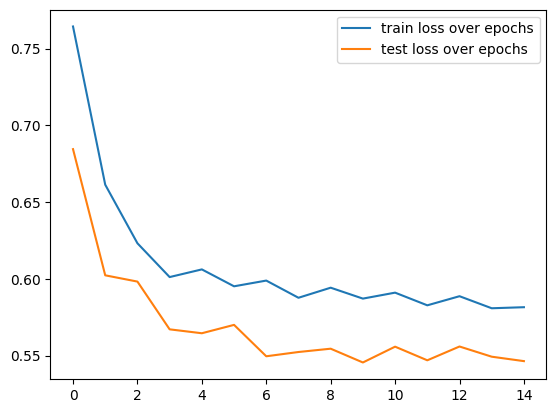

In [206]:
plt.plot(train_losses_2,label="train loss over epochs")
plt.plot(test_losses_2,label="test loss over epochs")
plt.legend()

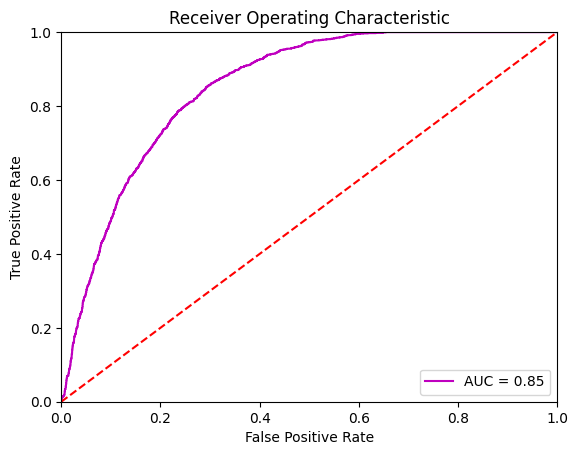

In [205]:
plt.title('Receiver Operating Characteristic')

plt.plot(fpr, tpr, 'b', label = 'ESM-2: AUC = %0.2f' % roc_auc)
plt.plot(fpr_1, tpr_1, 'y', label = 'ProtBERT: AUC = %0.2f' % roc_auc_1)
plt.plot(fpr_2, tpr_2, 'm', label = '3D-CNN: AUC = %0.2f' % roc_auc_2)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()